# Read the datasets & load libraries

In [1]:
%reset -f

In [2]:
from datasets import load_dataset, Dataset, load_from_disk, concatenate_datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
# nltk.download('punkt') 
from nltk.util import ngrams
from collections import Counter

import re
from transformers import pipeline
import requests

In [ ]:
train = load_dataset("allenai/mslr2022", "ms2", split="train")
val = load_dataset("allenai/mslr2022", "ms2", split="validation")
test = load_dataset("allenai/mslr2022", "ms2", split="test")

In [577]:
df_train = pd.DataFrame(train)
df_val = pd.DataFrame(val)
df_test = pd.DataFrame(test)

# EDA

## Overview of the dataset

In [578]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review_id   14188 non-null  object
 1   pmid        14188 non-null  object
 2   title       14188 non-null  object
 3   abstract    14188 non-null  object
 4   target      14188 non-null  object
 5   background  14188 non-null  object
dtypes: object(6)
memory usage: 665.2+ KB


In [579]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review_id   2021 non-null   object
 1   pmid        2021 non-null   object
 2   title       2021 non-null   object
 3   abstract    2021 non-null   object
 4   target      2021 non-null   object
 5   background  2021 non-null   object
dtypes: object(6)
memory usage: 94.9+ KB


In [580]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review_id   1667 non-null   object
 1   pmid        1667 non-null   object
 2   title       1667 non-null   object
 3   abstract    1667 non-null   object
 4   target      1667 non-null   object
 5   background  1667 non-null   object
dtypes: object(6)
memory usage: 78.3+ KB


## First 5 observations in the dataset

In [581]:
df_train.head()

,review_id,pmid,title,abstract,target,background
0,30760312,"[22776744, 25271670, 3493740, 1863023, 1629198...",[Improved Cell Survival and Paracrine Capacity...,[Although transplantation of adult bone marrow...,Conclusions SC therapy is effective for PAH in...,Background Despite significant progress in dru...
1,19588356,"[8532025, 10790348, 17504794, 16793845, 10733441]",[A comparison of continuous intravenous epopro...,[BACKGROUND Primary pulmonary hypertension is ...,There was a trend for endothelin receptor anta...,BACKGROUND Pulmonary arterial hypertension is ...
2,23893797,"[10637197, 14967718, 17599437, 22419603, 15170...",[Relationship of TIMI myocardial perfusion gra...,[BACKGROUND Although improved epicardial blood...,This present meta- analysis suggests that stat...,BACKGROUND To achieve sufficient myocardial pe...
3,27167891,"[24376277, 23328881, 21247734, 22140149, 42544...",[Effect of cessation interventions on hookah s...,[INTRODUCTION We explored the differential eff...,"In conclusion , there is a lack of evidence of...",Waterpipe tobacco smoking is growing in popula...
4,28753768,"[24322061, 24216616, 23632798, 8831469, 18176739]",[The Arizona Sexual Experiences Scale: a valid...,[INTRODUCTION Cultural sensitivities tend to l...,Several PROMs have been identified to evaluate...,CONTEXT Impaired sexual function has a signifi...


In [722]:
df_train.tail()

,review_id,pmid,title,abstract,target,background
14183,21672297,"[16938144, 7962886, 19341510, 17267928, 162608...",[Online randomized controlled trial of brief a...,[BACKGROUND Effective internet-based programs ...,BACKGROUND Cognitive-behavioural therapy (CBT)...,GSH differs in important respects from other l...
14184,18646120,"[12502620, 11063437, 10440120, 15738450, 14633...","[The prevention or delay of type 2 diabetes., ...",[D iabetes is one of the most costly and burde...,There are no high quality data on the efficacy...,BACKGROUND Prevention of type 2 diabetes in ad...
14185,25406011,"[21606131, 9745406, 15151714, 21917254, 151179...",[Use of metformin before and during assisted r...,[BACKGROUND To study the effect of metformin b...,This review found no conclusive evidence that ...,BACKGROUND The use of insulin-sensitising agen...
14186,27699761,"[27180030, 29119719, 4619985, 12634023, 389682...",[Effects of Child Care Intervention on Physica...,[INTRODUCTION This study evaluated whether int...,It is uncertain whether the strategies tested ...,BACKGROUND Despite the existence of effective ...
14187,30630416,"[2824145, 5154083, 24735841, 24491793, 5436415...","[A tutorial on pilot studies: the what, why an...",[Pilot studies for phase III trials - which ar...,Conclusion Published feasibility studies for S...,Background Stepped-wedge cluster r and omised ...


In [582]:
df_val.head()

,review_id,pmid,title,abstract,target,background
0,28514886,"[15870317, 20863418, 17991656, 15585783, 20032...",[Quantitative Real-Time PCR Assays To Identify...,[ABSTRACT A healthy intestinal microbiota is c...,Current evidence from systematic review and me...,Necrotizing enterocolitis ( NEC ) is one of th...
1,18842808,"[7872224, 15614200, 8247594, 17161227, 1595546...",[Effect of short-term ingestion of konjac gluc...,[The effects of the soluble fiber konjac gluco...,The use of glucomannan did not appear to signi...,BACKGROUND Several clinical trials have invest...
2,24297836,"[16055524, 21536612, 2700574, 3332564]",[Autonomic cardiovascular regulation in subjec...,[The aims of this study were 1 ) to evaluate w...,Ensuring that the characteristics of the histo...,PURPOSE The goal of this meta- analysis was to...
3,32367221,"[11685356, 17261567, 22928432, 26578718, 29741...",[Early post-operative morbidity following ante...,[Abstract . This study documented postoperativ...,The QT autograft detected comparable rate of L...,The purpose of the current study was to clarif...
4,25038833,"[16687205, 20597708, 22982689, 15643227, 16452...",[Differential effects of the antimuscarinic ag...,[OBJECTIVES To investigate the effects of dari...,medicines with anti-cholinergic properties hav...,OBJECTIVES to determine the effect of drugs wi...


In [723]:
df_val.tail()

,review_id,pmid,title,abstract,target,background
2016,19776504,"[7608367, 16352882, 11515644, 17123915, 852934...",[A three-year follow-up of glass ionomer cemen...,[The aim of the present study was to compare i...,This systematic review with meta- analysis fou...,The purpose of this quantitative systematic re...
2017,27505198,"[4596151, 16364497, 23265404, 17544361, 373580...",[Training response inhibition to food is assoc...,[The majority of adults in the UK and US are o...,A wide range of techniques have been evaluated...,OBJECTIVE This systematic review aim ed to ( a...
2018,25251296,"[24346474, 11333838, 10904454, 24500157, 20127...",[Follow-up of bone mineral density and body co...,[Background / Objectives : Restrictive Anorexi...,"First , during anorexia nervosa adolescent fem...",The aim of this paper was to conduct a systema...
2019,23235652,"[11731649, 9537309, 10357748, 16087985, 154478...",[Zinc supplementation in infants born small fo...,[BACKGROUND Low birth weight infants have been...,There is no convincing evidence that zinc supp...,BACKGROUND Zinc deficiency is a significant pu...
2020,30058911,"[12689998, 18541738, 25732273, 22162470, 18443...",['Mendelian randomization': can genetic epidem...,[Associations between modifiable exposures and...,We argue that despite inconsistencies in the d...,INTRODUCTION Obesity is a top public health pr...


In [583]:
df_test.head()

,review_id,pmid,title,abstract,target,background
0,24894943,"[19632716, 20573926, 23724913, 21903745]",[Radiotherapy plus chemotherapy with or withou...,[BACKGROUND Results from phase II studies in p...,,INTRODUCTION / BACKGROUND An individual patien...
1,25367179,"[19784660, 2390908, 16703429, 15496622, 179367...",[Effects of preoperative chemoradiotherapy on ...,[Purpose Deterioration of anorectal function a...,,Background Low rectal cancer is conventionally...
2,27841442,"[9550512, 12920254, 15929503, 19321521, 151942...",[Effect of a therapeutic intervention for the ...,[BACKGROUND AND PURPOSE Arm function recovery ...,,BACKGROUND Repetitive task training ( RTT ) in...
3,28764600,"[3527357, 4679833, 23842842, 4226213, 19250152...",[Internet-based psychoeducation for bipolar di...,[Background In a recent exploratory r and omis...,,There is a gap in knowledge of women 's percep...
4,26262909,"[15592289, 11110329, 10907623, 18768245, 13750...",[Sleep in late pregnancy predicts length of la...,[OBJECTIVE The purpose of this study was to te...,,BACKGROUND Leg cramps are a common problem in ...


In [724]:
df_test.tail()

,review_id,pmid,title,abstract,target,background
1662,23881744,"[16263773, 9831573, 109596, 16615955, 19573436...",[Effect of intravenous amino acids on glutamin...,[Glutamine may be a conditionally essential am...,NaN,BACKGROUND Observational studies in preterm ne...
1663,28780119,"[23402113, 19428896, 3196245, 16595307]",[Efficacy of a Recombinant HVT-H5 Vaccine Agai...,[SUMMARY . The swift evolution rate of avian i...,NaN,Indonesia has implemented multiple strategies ...
1664,29724255,"[3355143, 5339014, 21548817, 27352492, 2062605...",[Acupuncture for the Treatment of Dry Eye: A M...,[Purpose To evaluate the effects of acupunctur...,NaN,Abstract s Background In a former meta- analys...
1665,24756870,"[12971705, 12920254, 11812553, 22544817, 33492...",[A study on additional early physiotherapy aft...,[Objective : To investigate whether additional...,NaN,BACKGROUND Various approaches to physical reha...
1666,30151019,"[23188543, 27219115, 5362830, 6041915, 2154881...","[A Phase II, Randomized, Controlled Trial of A...",[Purpose Postoperative ileus ( POI ) prolongs ...,NaN,Delays in recovery of intestinal function foll...


## Check for duplication

### Train Set: Abstract

In [585]:
unique_tr_abstract = df_train['abstract'].apply(lambda x: tuple(x) if isinstance(x, list) else x).nunique()
print(f"Number of unique abstract observations:", unique_tr_abstract)


Number of unique abstract observations: 14159


In [607]:
# Convert abstract column to frozenset to handle lists
df_train['abstract_frozenset'] = df_train['abstract'].apply(frozenset)

# Identify duplicate rows based on the new column of frozensets
tr_abstract_duplicates = df_train.duplicated(subset=['abstract_frozenset'], keep=False)

# Print the rows where duplicates occur
print(df_train[tr_abstract_duplicates]['abstract'])
print(f"Number of duplicated abstract observations:", len(df_train[tr_abstract_duplicates]))
df_train.drop('abstract_frozenset', axis=1, inplace=True)

190      [OBJECTIVE To compare the effectiveness of ann...
234      [BACKGROUND This study examined the nurse outc...
351      [We conducted a r and omized , double-blind , ...
930      [There are no data on the prevalence and other...
1480     [There are no data on the prevalence and other...
1522     [Background : The Women 's Health Initiative r...
1952     [AIM To assess the efficacy and safety of a co...
2555     [Effects of nutritional supplements on minimiz...
2570     [This study describes the results of a control...
2762     [We conducted a r and omized , double-blind , ...
2957     [The purpose of this study is to compare bleed...
2973     [The auditory brainstem response reflects neur...
3201     [OBJECTIVES The aim of the present study was t...
3207     [The long-term effect of two parent training p...
3283     [OBJECTIVES To compare different treatment reg...
3834     [BACKGROUND Knee arthroscopy is among the most...
4000     [The purpose of this study is to compare bleed.

In [587]:
print(df_train['abstract'][190])
print(df_train['abstract'][7002])

['OBJECTIVE To compare the effectiveness of annual topical application of silver diamine fluoride ( SDF ) solution , semi-annual topical application of SDF solution , and annual application of a flowable high fluoride-releasing glass ionomer in arresting active dentine caries in primary teeth . METHODS A total of 212 children , aged 3 - 4 years , were r and omly allocated to one of three groups for treatment of carious dentine cavities in their primary teeth :  Gp1-annual application of SDF , Gp2-semi-annual application of SDF , and Gp3-annual application of glass ionomer . Follow-up examinations were carried out every six months to assess whether the treated caries lesions had become arrested . RESULTS After 24 months , 181 ( 85 % ) children remained in the study . The caries arrest rates were 79 % , 91 % and 82 % for Gp1 , Gp2 and Gp3 , respectively ( p=0.007 ) . In the logistic regression model using GEE to adjust for clustering effect , higher caries arrest rates were found in lesi

In [588]:
print(df_train['target'][190])
print(df_train['target'][7002])

RESULTS The panel made a conditional recommendation regarding the use of 38 percent SDF for the arrest of cavitated caries lesions in primary teeth as part of a comprehensive caries management program .
After taking into consideration the low cost of the treatment and the disease burden of caries , panel members were confident that the benefits of SDF application in the target population s outweigh its possible undesirable effects .
Per GRADE , this is a conditional recommendation based on low- quality evidence .
RESULTS The panel made a conditional recommendation regarding the use of 38 percent SDF for the arrest of cavitated caries lesions in primary teeth as part of a comprehensive caries management program .
After taking into consideration the low cost of the treatment and the disease burden of caries , panel members were confident that the benefits of SDF application in the target population s outweigh its possible undesirable effects .
Per GRADE , this is a conditional recommenda

### Train Set: Target

In [589]:
unique_tr_target = df_train['target'].nunique()
print(f"Number of unique target observations:", unique_tr_target)

Number of unique target observations: 14162


In [590]:
tr_target_duplicates = df_train[df_train.duplicated(subset=['target'], keep=False)]
print(tr_target_duplicates['target'])
print(f"Number of duplicated target observations:", len(tr_target_duplicates))


190      RESULTS The panel made a conditional recommend...
247      Intraoperative goal directed hemodynamic thera...
812      Home participants underwent fewer investigatio...
1012     There is currently no systematic evidence to g...
1522     The studies least likely to be affected by bia...
1755     Intraoperative goal directed hemodynamic thera...
1925     Authors ' conclusions In individual patients ,...
1952     Alginates are more effective than placebo or a...
2243     Current evidence is insufficient to support Py...
2250     Nonetheless the clinical question remains : is...
2570     This review provides no evidence that fibre su...
2627     All OHAs were effective when added to metformi...
2674     From the available evidence , we are unable to...
2957     There is limited evidence for pain improvement...
3183     All OHAs were effective when added to metformi...
3201     They also concluded that sealants could minimi...
3207     Moreover , the intervention demonstrated evide.

In [591]:
print(df_train['target'][3201])
print(df_train['target'][4629])
print(df_train['target'][5473])

They also concluded that sealants could minimize the progression of non-cavitated occlusal carious lesions ( also referred to as initial lesions ) that receive a sealant .
Finally , based on the available limited evidence , the panel was unable to provide specific recommendations on the relative merits of 1 type of sealant material over the others .
They also concluded that sealants could minimize the progression of non-cavitated occlusal carious lesions ( also referred to as initial lesions ) that receive a sealant .
Finally , based on the available limited evidence , the panel was unable to provide specific recommendations on the relative merits of 1 type of sealant material over the others .
They also concluded that sealants could minimize the progression of non-cavitated occlusal carious lesions ( also referred to as initial lesions ) that receive a sealant .
Finally , based on the available limited evidence , the panel was unable to provide specific recommendations on the relative

In [592]:
df_train['target'][4629] == df_train['target'][5473] == df_train['target'][3201]

True

In [593]:
print(df_train['abstract'][3201])
print(df_train['abstract'][4629])
print(df_train['abstract'][5473])

['OBJECTIVES The aim of the present study was to investigate the caries-preventive effect of sealants produced with a high-viscosity glass-ionomer with an elevated powder-liquid ratio ( ART ) , of having energy added to this glass-ionomer , and that of glass-carbomer , in comparison to that of resin composite sealants . METHODS The r and omized controlled trial covered 407 children , with a mean age of 8 years . At a school compound three dentists placed sealants in pits and fissures of high caries-risk children . Evaluation by two independent evaluators was conducted after 0.5 , 1 and 2 years . The Kaplan-Meier survival method , ANOVA and t-test were used in analyzing the data . RESULTS 1352 first permanent molars were sealed . 6.6 % of children and 6.8 % of sealants dropped out within 2 years . 27 re-exposed pits and fissures , 20 in occlusal and 7 in smooth surfaces , in 25 children , developed a dentin carious lesion . The cumulative survival of dentin carious lesion-free pits and 

### Validation Set: Abstract

In [596]:
unique_v_abstract = df_val['abstract'].apply(lambda x: tuple(x) if isinstance(x, list) else x).nunique()
print(f"Number of unique abstract observations:", unique_v_abstract)


Number of unique abstract observations: 2018


In [610]:
# Convert abstract column to frozenset to handle lists
df_val['abstract_frozenset'] = df_val['abstract'].apply(frozenset)

# Identify duplicate rows based on the new column of frozensets
v_abstract_duplicates = df_val.duplicated(subset=['abstract_frozenset'], keep=False)

# Print the rows where duplicates occur
print(df_val[v_abstract_duplicates]['abstract'])
print(f"Number of duplicated abstract observations:", len(df_val[v_abstract_duplicates]))
df_val.drop('abstract_frozenset', axis=1, inplace=True)

269     [UNLABELLED The aim of the study is to compare...
648     [UNLABELLED The aim of the study is to compare...
1071    [Background Scotl and has a policy aim ed at i...
1314    [Background Scotl and has a policy aim ed at i...
1397    [OBJECTIVE To examine the efficacy of a 3-mont...
1632    [OBJECTIVE To examine the efficacy of a 3-mont...
Name: abstract, dtype: object
Number of duplicated abstract observations: 6


### Validation Set: Target

In [599]:
unique_v_target = df_val['target'].nunique()
print(f"Number of unique target observations:", unique_v_target)

Number of unique target observations: 2016


In [600]:
v_target_duplicates = df_val[df_val.duplicated(subset=['target'], keep=False)]
print(v_target_duplicates['target'])
print(f"Number of duplicated target observations:", len(v_target_duplicates))


213     Some evidence indicates that combination thera...
707     We found that whilst most studies employing ba...
891     Calcium was more effective than placebo in red...
941     We found that whilst most studies employing ba...
1266    REVIEW ER 'S CONCLUSIONS Quitting smoking is a...
1397    The adverse events associated with the antihyp...
1629    Some evidence indicates that combination thera...
1632    The adverse events associated with the antihyp...
1645    Calcium was more effective than placebo in red...
1805    REVIEW ER 'S CONCLUSIONS Quitting smoking is a...
Name: target, dtype: object
Number of duplicated target observations: 10


### Test Set: Abstract

In [601]:
unique_te_abstract = df_test['abstract'].apply(lambda x: tuple(x) if isinstance(x, list) else x).nunique()
print(f"Number of unique abstract observations:", unique_te_abstract)


Number of unique abstract observations: 1666


In [605]:
# Convert abstract column to frozenset to handle lists
df_test['abstract_frozenset'] = df_test['abstract'].apply(frozenset)

# Identify duplicate rows based on the new column of frozensets
te_abstract_duplicates = df_test.duplicated(subset=['abstract_frozenset'], keep=False)

# Print the rows where duplicates occur
print(df_test[te_abstract_duplicates]['abstract'])
print(f"Number of duplicated abstract observations:", len(df_test[te_abstract_duplicates]))
df_test.drop('abstract_frozenset', axis=1, inplace=True)

97      [OBJECTIVE To compare the efficacy and safety ...
1060    [OBJECTIVE To compare the efficacy and safety ...
Name: abstract, dtype: object
Number of duplicated abstract observations: 2


## Check for missing values

In [612]:
# Replace white spaces with null value
df_train.replace('', np.nan, inplace=True)
df_val.replace('', np.nan, inplace=True)
df_test.replace('', np.nan, inplace=True)

In [613]:
# Replace string 'nan' with null value
df_train.replace('nan', np.nan, inplace=True)
df_val.replace('nan', np.nan, inplace=True)
df_test.replace('nan', np.nan, inplace=True)

In [614]:
df_train.isnull().sum()

review_id       0
pmid            0
title           0
abstract        0
target          0
background    209
dtype: int64

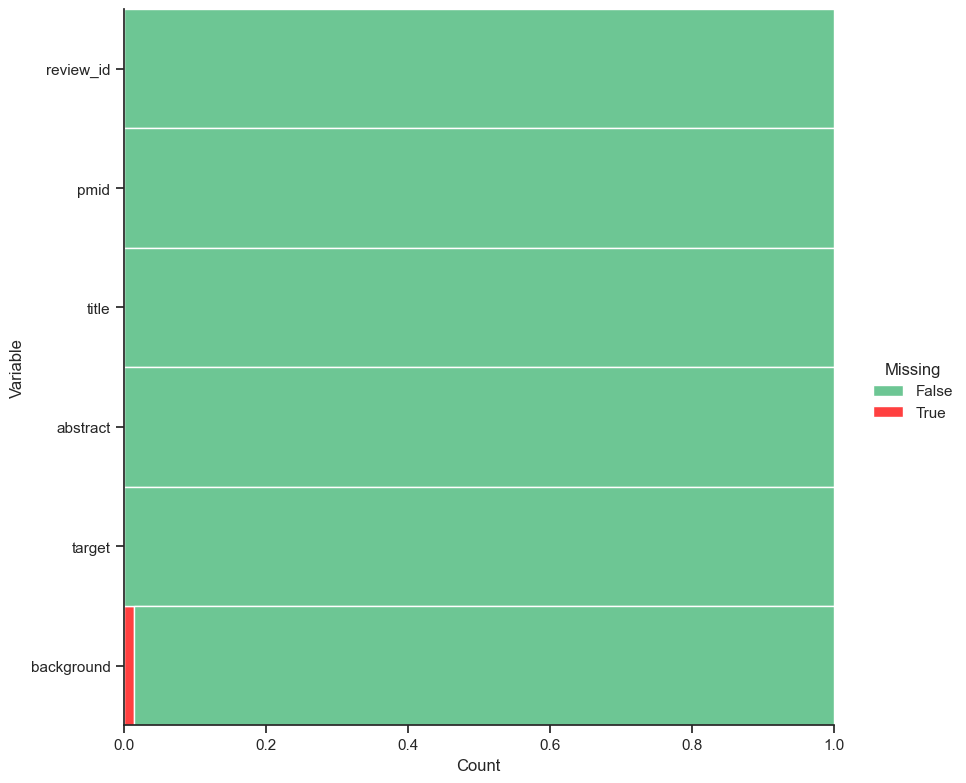

In [615]:
sns.displot(
    data=df_train.isnull().melt(value_name='Missing'),
    y='variable',
    hue='Missing',
    multiple='fill',
    height=8,
    aspect=1.1,
    palette={True: 'red', False: 'mediumseagreen'}
)

plt.ylabel("Variable")
plt.show()

In [616]:
df_val.isnull().sum()

review_id      0
pmid           0
title          0
abstract       0
target         0
background    38
dtype: int64

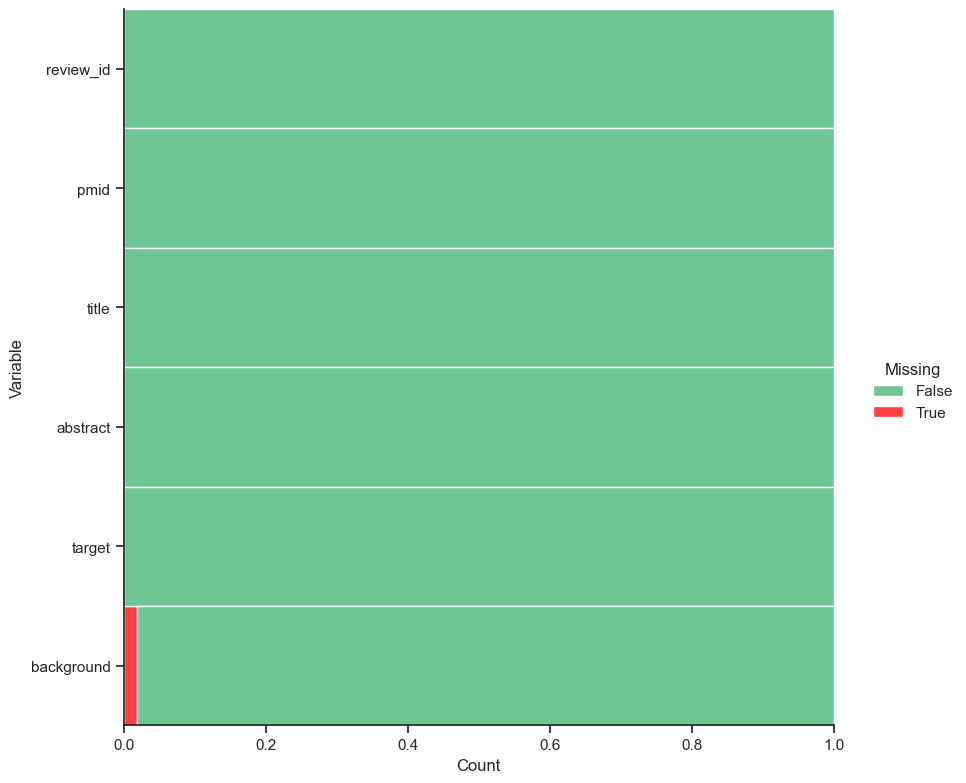

In [617]:
sns.displot(
    data=df_val.isnull().melt(value_name='Missing'),
    y='variable',
    hue='Missing',
    multiple='fill',
    height=8,
    aspect=1.1,
    palette={True: 'red', False: 'mediumseagreen'}
)

plt.ylabel("Variable")
plt.show()

In [618]:
df_test.isnull().sum()

review_id        0
pmid             0
title            0
abstract         0
target        1667
background      52
dtype: int64

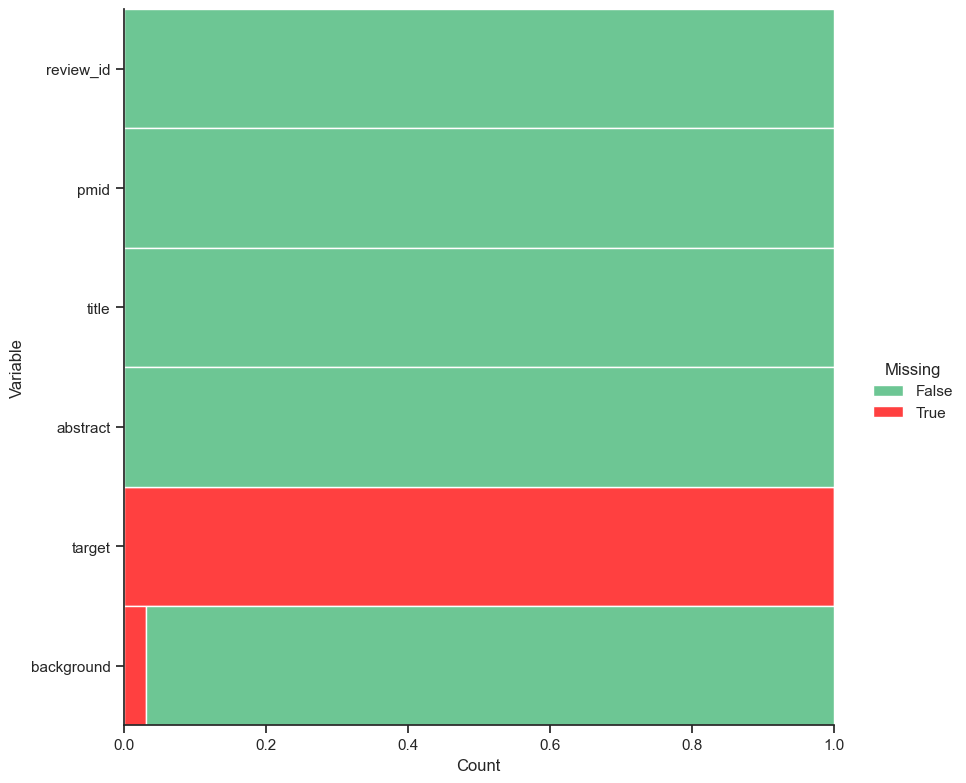

In [619]:
sns.displot(
    data=df_test.isnull().melt(value_name='Missing'),
    y='variable',
    hue='Missing',
    multiple='fill',
    height=8,
    aspect=1.1,
    palette={True: 'red', False: 'mediumseagreen'}
)

plt.ylabel("Variable")
plt.show()

## Source analysis

### PMIDs 

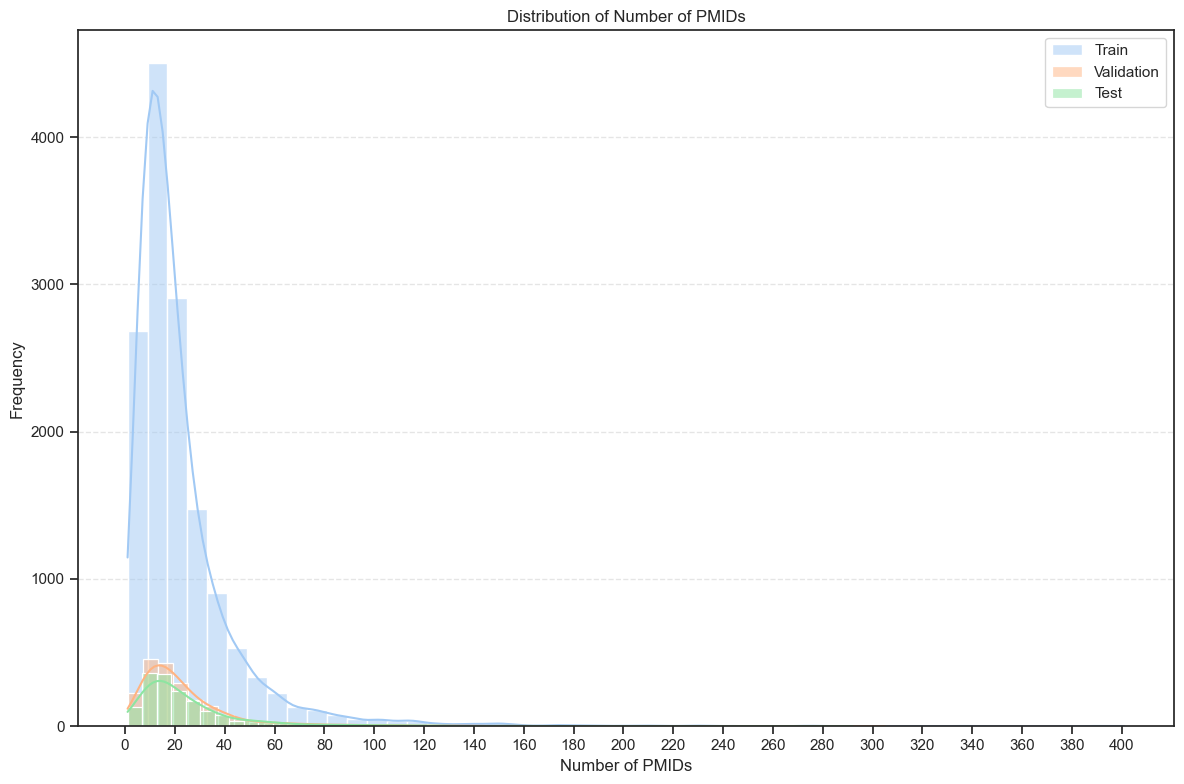

In [620]:
# Calculate the number of IDs in each row
train_pmid = df_train['pmid'].apply(len)
val_pmid = df_val['pmid'].apply(len)
test_pmid = df_test['pmid'].apply(len)

# Visualize the distribution for train, validation, and test datasets
plt.figure(figsize=(12, 8))

# Plot histogram for train dataset
sns.histplot(train_pmid, bins=50, kde=True, label='Train', alpha=0.5)

# Plot histogram for validation dataset
sns.histplot(val_pmid, bins=50, kde=True, label='Validation', alpha=0.5)

# Plot histogram for test dataset
sns.histplot(test_pmid, bins=50, kde=True, label='Test', alpha=0.5)

# Customize plot properties
plt.title('Distribution of Number of PMIDs')
plt.xlabel('Number of PMIDs')
plt.ylabel('Frequency')
plt.xticks(range(0, 401, 20))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Train set

In [621]:
train_pmid.describe()

count    14188.000000
mean        22.808571
std         24.199262
min          1.000000
25%         10.000000
50%         16.000000
75%         27.000000
max        401.000000
Name: pmid, dtype: float64

In [622]:
min_row_index = train_pmid.idxmin()
min_row = df_train.loc[min_row_index]

print(min_row)
print(min_row['title'])

review_id                                              22513917
pmid                                                 [23956241]
title         [Memantine for the prevention of cognitive dys...
abstract      [BACKGROUND To determine the protective effect...
target        None of the RCTs with altered WBRT dose-fracti...
background    BACKGROUND Brain metastases represent a signif...
Name: 14, dtype: object
['Memantine for the prevention of cognitive dysfunction in patients receiving whole-brain radiotherapy: a randomized, double-blind, placebo-controlled trial.']


### Validation set

In [623]:
val_pmid.describe()

count    2021.000000
mean       24.246413
std        23.135730
min         1.000000
25%        11.000000
50%        18.000000
75%        29.000000
max       305.000000
Name: pmid, dtype: float64

### Test set

In [624]:
test_pmid.describe()

count    1667.000000
mean       25.628674
std        25.111123
min         1.000000
25%        12.000000
50%        18.000000
75%        30.000000
max       292.000000
Name: pmid, dtype: float64

### Titles

In [625]:
# Calculate the number of IDs in each row
train_title = df_train['title'].apply(len)
val_title = df_val['title'].apply(len)
test_title = df_test['title'].apply(len)

In [626]:
train_title.describe()

count    14188.000000
mean        22.808571
std         24.199262
min          1.000000
25%         10.000000
50%         16.000000
75%         27.000000
max        401.000000
Name: title, dtype: float64

In [627]:
val_title.describe()

count    2021.000000
mean       24.246413
std        23.135730
min         1.000000
25%        11.000000
50%        18.000000
75%        29.000000
max       305.000000
Name: title, dtype: float64

In [628]:
test_title.describe()

count    1667.000000
mean       25.628674
std        25.111123
min         1.000000
25%        12.000000
50%        18.000000
75%        30.000000
max       292.000000
Name: title, dtype: float64

## Distribution of metafeatures

In [396]:
def create_text_features(data, column_name):
    df_dist = pd.DataFrame()
    # Remove punctuations
    df_dist[f'{column_name}'] = data[column_name].apply(lambda x: ''.join([c for c in str(x) if c not in string.punctuation]))
    # Word frequency from data without punctuation
    df_dist['word_count'] = df_dist[f'{column_name}'].apply(lambda x: len(str(x).split()))
    # Unique word frequency from data without punctuation
    df_dist['unique_word_count'] = df_dist[f'{column_name}'].apply(lambda x: len(set(str(x).split())))
    # Stop word frequency from data without punctuation
    df_dist['stop_word_count'] = df_dist[f'{column_name}'].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
    # Average word length (characters for each word) from data without punctuation
    df_dist['mean_word_length'] = df_dist[f'{column_name}'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # Character length (with spaces) frequency from data without punctuation
    df_dist['char_count'] = df_dist[f'{column_name}'].apply(lambda x: len(str(x)))
    # Url frequency from original data with punctuation
    df_dist['url_count'] = data[column_name].apply(lambda x: len([w for w in str(x).lower().split() if 'http:' in w or 'https:' in w]))
    # Punctuation frequency from original data with punctuation
    df_dist['punctuation_count'] = data[column_name].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    return df_dist

In [630]:
ab_dist_train = create_text_features(df_train, 'abstract')
ab_dist_val = create_text_features(df_val, 'abstract')
ab_dist_test = create_text_features(df_test, 'abstract')

tar_dist_train = create_text_features(df_train, 'target')
tar_dist_val = create_text_features(df_val, 'target')
tar_dist_test = create_text_features(df_test, 'target')

C:\Users\ellae\AppData\Local\Temp\ipykernel_30152\1711756423.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ab_dist_train[feature], label='Train Abstract', ax=axes[i, 0])
C:\Users\ellae\AppData\Local\Temp\ipykernel_30152\1711756423.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ab_di

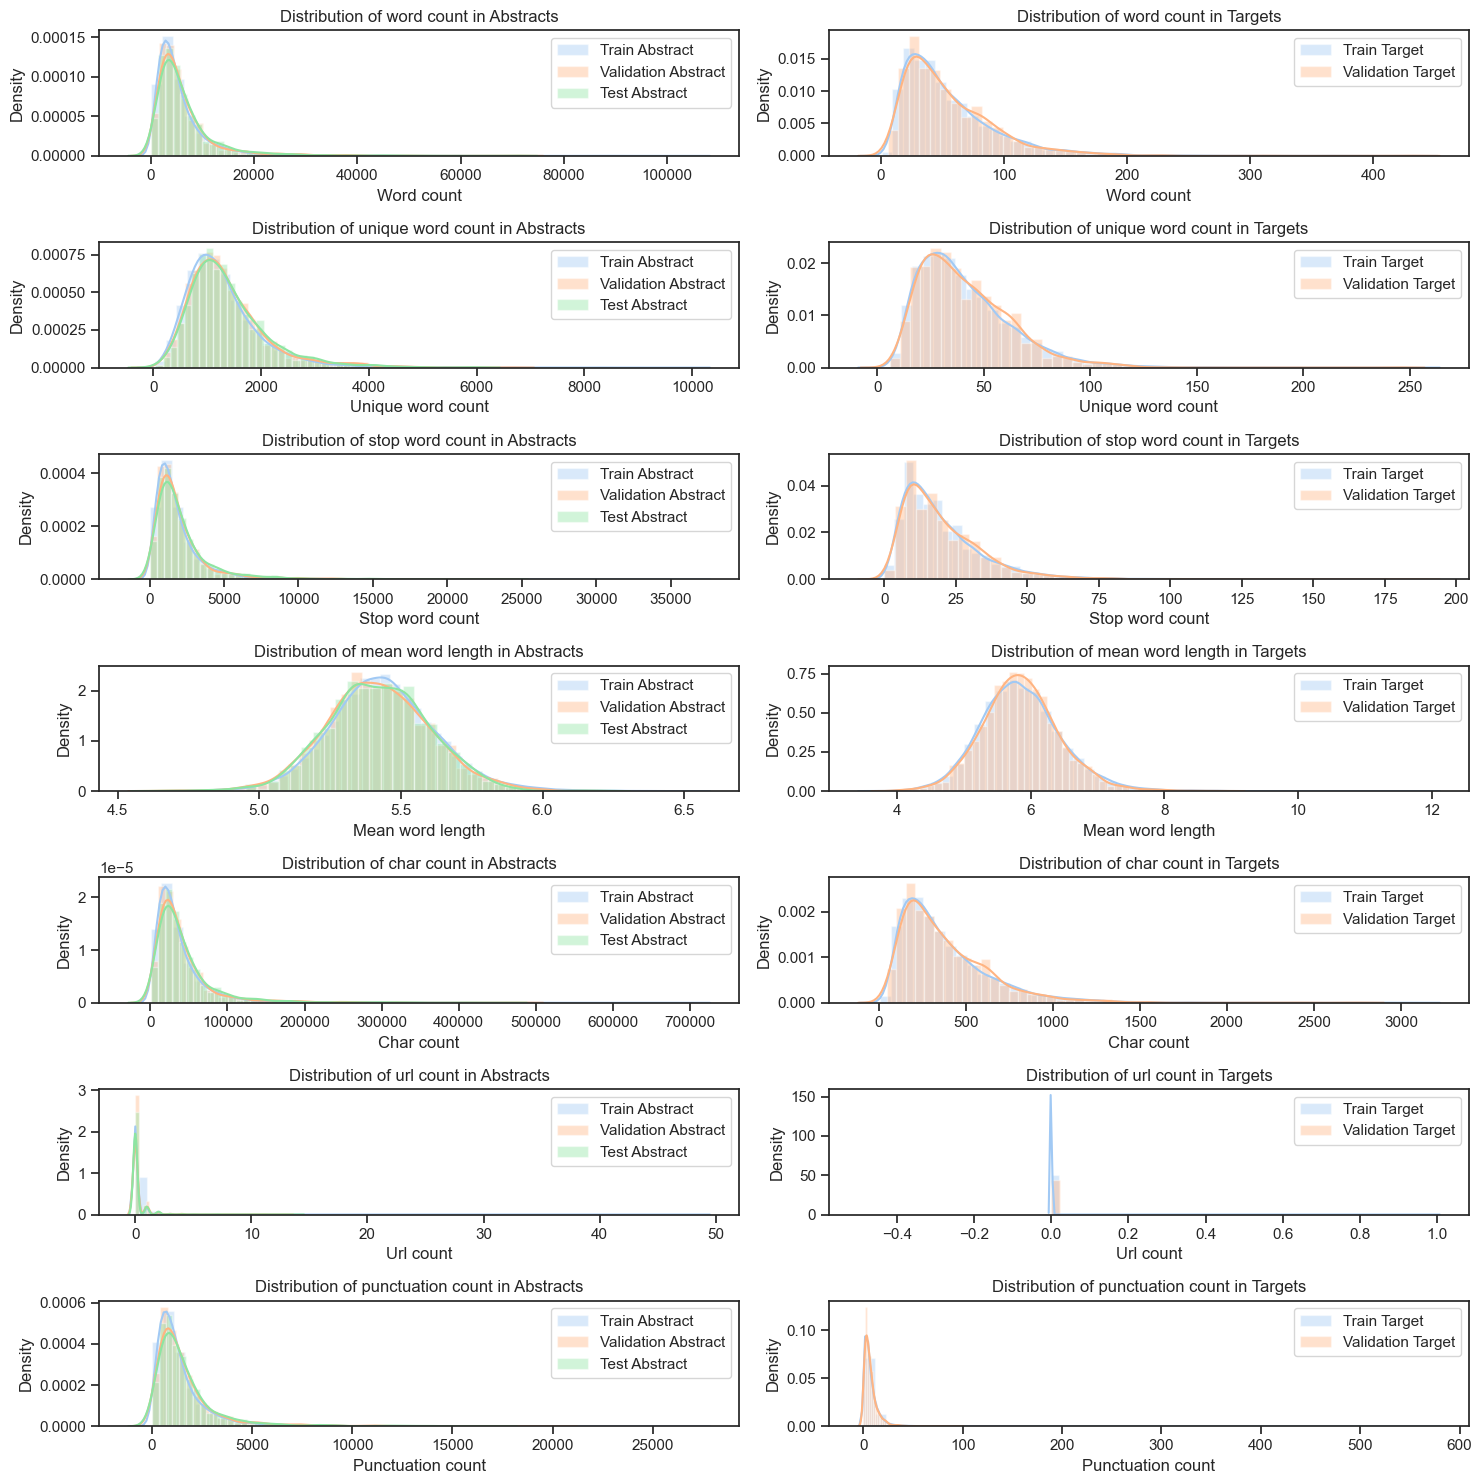

In [635]:
features = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count', 
            'url_count', 'punctuation_count']

# Create subplots
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(15, 15), dpi=100)

# Process and plot distributions for abstracts
for i, feature in enumerate(features):
    # Plot distributions on the same figure using distplot
    sns.distplot(ab_dist_train[feature], label='Train Abstract', ax=axes[i, 0])
    sns.distplot(ab_dist_val[feature], label='Validation Abstract', ax=axes[i, 0])
    sns.distplot(ab_dist_test[feature], label='Test Abstract', ax=axes[i, 0])
    
    # Customize the plot
    feature_name = feature.replace('_', ' ')
    axes[i, 0].set_title(f'Distribution of {feature_name} in Abstracts')
    axes[i, 0].set_xlabel(feature_name.capitalize())
    axes[i, 0].set_ylabel('Density')
    axes[i, 0].legend()

# Process and plot distributions for targets
for i, feature in enumerate(features):
    # Plot distributions on the same figure using distplot
    sns.distplot(tar_dist_train[feature], label='Train Target', ax=axes[i, 1])
    sns.distplot(tar_dist_val[feature], label='Validation Target', ax=axes[i, 1])
    # sns.distplot(tar_dist_test[feature], label='Test Target', ax=axes[i, 1])
    
    # Customize the plot
    feature_name = feature.replace('_', ' ')
    axes[i, 1].set_title(f'Distribution of {feature_name} in Targets')
    axes[i, 1].set_xlabel(feature_name.capitalize())
    axes[i, 1].set_ylabel('Density')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [646]:
ab_dist_train.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,14188.000000,14188.000000,14188.000000,14188.000000,14188.000000,14188.000000,14188.000000
mean,5818.351988,1293.246476,1942.895546,5.437584,38448.215675,0.208204,1462.484705
std,6190.275487,737.342097,2061.315950,0.188903,40987.731052,1.129051,1582.006546
min,38.000000,30.000000,11.000000,4.705357,259.000000,0.000000,8.000000
25%,2516.750000,819.000000,842.000000,5.314568,16643.250000,0.000000,595.000000
50%,4178.000000,1150.000000,1396.000000,5.430616,27624.000000,0.000000,1036.000000
75%,6918.250000,1585.000000,2302.000000,5.553330,45656.000000,0.000000,1747.250000
max,105524.000000,10001.000000,36720.000000,6.507463,707681.000000,49.000000,27143.000000


In [647]:
ab_dist_val.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,6224.988125,1365.461158,2059.258783,5.418779,41000.968827,0.265710,1622.260762
std,6106.617536,736.126075,2002.904716,0.184888,40085.945675,0.921233,1662.635685
min,108.000000,72.000000,47.000000,4.658017,752.000000,0.000000,22.000000
25%,2780.000000,876.000000,932.000000,5.297819,18591.000000,0.000000,672.000000
50%,4557.000000,1217.000000,1499.000000,5.415137,30012.000000,0.000000,1155.000000
75%,7324.000000,1678.000000,2424.000000,5.537244,48310.000000,0.000000,1946.000000
max,72011.000000,6583.000000,23476.000000,6.139040,483393.000000,13.000000,20129.000000


In [648]:
ab_dist_test.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000
mean,6553.088182,1387.734853,2176.689862,5.420753,43188.044391,0.217756,1679.432513
std,6446.715296,736.396386,2129.615463,0.179758,42486.041115,0.783210,1729.931550
min,43.000000,36.000000,19.000000,4.669580,259.000000,0.000000,8.000000
25%,2890.500000,901.500000,969.500000,5.303018,19046.000000,0.000000,698.000000
50%,4712.000000,1236.000000,1563.000000,5.420461,31173.000000,0.000000,1181.000000
75%,7709.000000,1710.500000,2576.500000,5.540609,50947.000000,0.000000,1989.500000
max,70498.000000,5930.000000,23972.000000,6.186340,459691.000000,14.000000,17035.000000


In [649]:
tar_dist_train.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,14188.000000,14188.000000,14188.000000,14188.000000,14188.000000,14188.000000,14188.000000
mean,55.665140,41.481252,20.164505,5.855895,383.778052,0.000211,7.351001
std,39.413293,22.521320,14.851470,0.614888,270.735501,0.014540,9.154778
min,1.000000,1.000000,0.000000,3.692308,11.000000,0.000000,0.000000
25%,28.000000,25.000000,10.000000,5.444444,194.000000,0.000000,3.000000
50%,45.000000,37.000000,16.000000,5.816784,309.000000,0.000000,5.000000
75%,72.000000,53.000000,26.000000,6.213115,498.000000,0.000000,9.000000
max,435.000000,254.000000,169.000000,11.844828,3101.000000,1.000000,576.000000


In [650]:
tar_dist_val.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.0,2021.000000
mean,55.434438,41.388916,20.090549,5.858259,382.205344,0.0,7.366155
std,36.938433,21.181936,14.025479,0.578770,253.364022,0.0,7.913050
min,6.000000,6.000000,0.000000,4.000000,49.000000,0.0,0.000000
25%,28.000000,25.000000,10.000000,5.489796,196.000000,0.0,3.000000
50%,46.000000,37.000000,17.000000,5.835443,316.000000,0.0,5.000000
75%,74.000000,54.000000,27.000000,6.200000,511.000000,0.0,9.000000
max,430.000000,243.000000,185.000000,8.818182,2735.000000,0.0,96.000000


In [651]:
tar_dist_test.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,1667.0,1667.0,1667.0,1667.0,1667.0,1667.0,1667.0
mean,1.0,1.0,0.0,3.0,3.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,0.0,3.0,3.0,0.0,0.0
25%,1.0,1.0,0.0,3.0,3.0,0.0,0.0
50%,1.0,1.0,0.0,3.0,3.0,0.0,0.0
75%,1.0,1.0,0.0,3.0,3.0,0.0,0.0
max,1.0,1.0,0.0,3.0,3.0,0.0,0.0


## N-gram analysis

In [717]:
def documentNgrams(documents, size):
    ngrams_all = []
    if 'abstract' in  documents.name:
        for abstract in documents:
            # print(abstract)
            for study in abstract:
                tokens = word_tokenize(study.lower())
                # Remove stopwords and non-alphanumeric characters such as punctuation and special symbols
                tokens = [token for token in tokens if token.isalnum() and token not in set(stopwords.words('english'))]
                # print(tokens)
                if len(tokens) <= size:
                    continue
                else:
                    output = list(ngrams(tokens, size))
                for ngram in output:
                    ngrams_all.append(" ".join(ngram))
    else:
        for target in documents:
            # print(target)
            tokens = word_tokenize(target.lower())
            # Remove stopwords and non-alphanumeric characters such as punctuation and special symbols
            tokens = [token for token in tokens if token.isalnum() and token not in set(stopwords.words('english'))]
            # print(tokens)
            if len(tokens) <= size:
                continue
            else:
                output = list(ngrams(tokens, size))
            for ngram in output:
                ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by='count', ascending=False)
    print(df.shape)
    df = df.head(10)
    df = df.sort_values(by='count')
    return df

def plotNgrams(train_documents, val_documents, test_documents):
    unigrams_train = documentNgrams(train_documents, 1)
    bigrams_train = documentNgrams(train_documents, 2)
    trigrams_train = documentNgrams(train_documents, 3)

    unigrams_val = documentNgrams(val_documents, 1)
    bigrams_val = documentNgrams(val_documents, 2)
    trigrams_val = documentNgrams(val_documents, 3)
    
    if 'abstract' in  test_documents.name:
        unigrams_test = documentNgrams(test_documents, 1)
        bigrams_test = documentNgrams(test_documents, 2)
        trigrams_test = documentNgrams(test_documents, 3)
    elif 'target' in test_documents.name:
        print("Skipping processing and plotting for 'target' in test_documents.")
    
    # Set plot figure size
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))
    plt.subplots_adjust(wspace=.5)
    
    # Plot unigrams
    axes[0, 0].barh(np.arange(len(unigrams_train['words'])), unigrams_train['count'], align='center', alpha=.5, color='red')
    axes[0, 0].set_title('Top 10 most common unigrams in Train')
    axes[0, 0].set_yticks(np.arange(len(unigrams_train['words'])))
    axes[0, 0].set_yticklabels(unigrams_train['words'])
    axes[0, 0].set_xlabel('Count')

    axes[0, 1].barh(np.arange(len(unigrams_val['words'])), unigrams_val['count'], align='center', alpha=.5, color='orangered')
    axes[0, 1].set_title('Top 10 most common unigrams in Validation')
    axes[0, 1].set_yticks(np.arange(len(unigrams_val['words'])))
    axes[0, 1].set_yticklabels(unigrams_val['words'])
    axes[0, 1].set_xlabel('Count')

    if 'abstract' in test_documents.name:
        axes[0, 2].barh(np.arange(len(unigrams_test['words'])), unigrams_test['count'], align='center', alpha=.5, color='gold')
        axes[0, 2].set_title('Top 10 most common unigrams in Test')
        axes[0, 2].set_yticks(np.arange(len(unigrams_test['words'])))
        axes[0, 2].set_yticklabels(unigrams_test['words'])
        axes[0, 2].set_xlabel('Count')

    # Plot bigrams
    axes[1, 0].barh(np.arange(len(bigrams_train['words'])), bigrams_train['count'], align='center', alpha=.5, color='darkblue')
    axes[1, 0].set_title('Top 10 most common bigrams in Train')
    axes[1, 0].set_yticks(np.arange(len(bigrams_train['words'])))
    axes[1, 0].set_yticklabels(bigrams_train['words'])
    axes[1, 0].set_xlabel('Count')

    axes[1, 1].barh(np.arange(len(bigrams_val['words'])), bigrams_val['count'], align='center', alpha=.5, color='indigo')
    axes[1, 1].set_title('Top 10 most common bigrams in Validation')
    axes[1, 1].set_yticks(np.arange(len(bigrams_val['words'])))
    axes[1, 1].set_yticklabels(bigrams_val['words'])
    axes[1, 1].set_xlabel('Count')

    if 'abstract' in test_documents.name:
        axes[1, 2].barh(np.arange(len(bigrams_test['words'])), bigrams_test['count'], align='center', alpha=.5, color='hotpink')
        axes[1, 2].set_title('Top 10 most common bigrams in Test')
        axes[1, 2].set_yticks(np.arange(len(bigrams_test['words'])))
        axes[1, 2].set_yticklabels(bigrams_test['words'])
        axes[1, 2].set_xlabel('Count')

    # Plot trigrams
    axes[2, 0].barh(np.arange(len(trigrams_train['words'])), trigrams_train['count'], align='center', alpha=.5, color='darkgreen')
    axes[2, 0].set_title('Top 10 most common trigrams in Train')
    axes[2, 0].set_yticks(np.arange(len(trigrams_train['words'])))
    axes[2, 0].set_yticklabels(trigrams_train['words'])
    axes[2, 0].set_xlabel('Count')

    axes[2, 1].barh(np.arange(len(trigrams_val['words'])), trigrams_val['count'], align='center', alpha=.5, color='turquoise')
    axes[2, 1].set_title('Top 10 most common trigrams in Validation')
    axes[2, 1].set_yticks(np.arange(len(trigrams_val['words'])))
    axes[2, 1].set_yticklabels(trigrams_val['words'])
    axes[2, 1].set_xlabel('Count')
    
    if 'abstract' in test_documents.name:
        axes[2, 2].barh(np.arange(len(trigrams_test['words'])), trigrams_test['count'], align='center', alpha=.5, color='lightgreen')
        axes[2, 2].set_title('Top 10 most common trigrams in Test')
        axes[2, 2].set_yticks(np.arange(len(trigrams_test['words'])))
        axes[2, 2].set_yticklabels(trigrams_test['words'])
        axes[2, 2].set_xlabel('Count')

    plt.show()


### Abstract Ngram Anlaysis

(176285, 2)
(6834424, 2)
(19330780, 2)
(65226, 2)
(1826486, 2)
(4014589, 2)
(58585, 2)
(1553512, 2)
(3333395, 2)


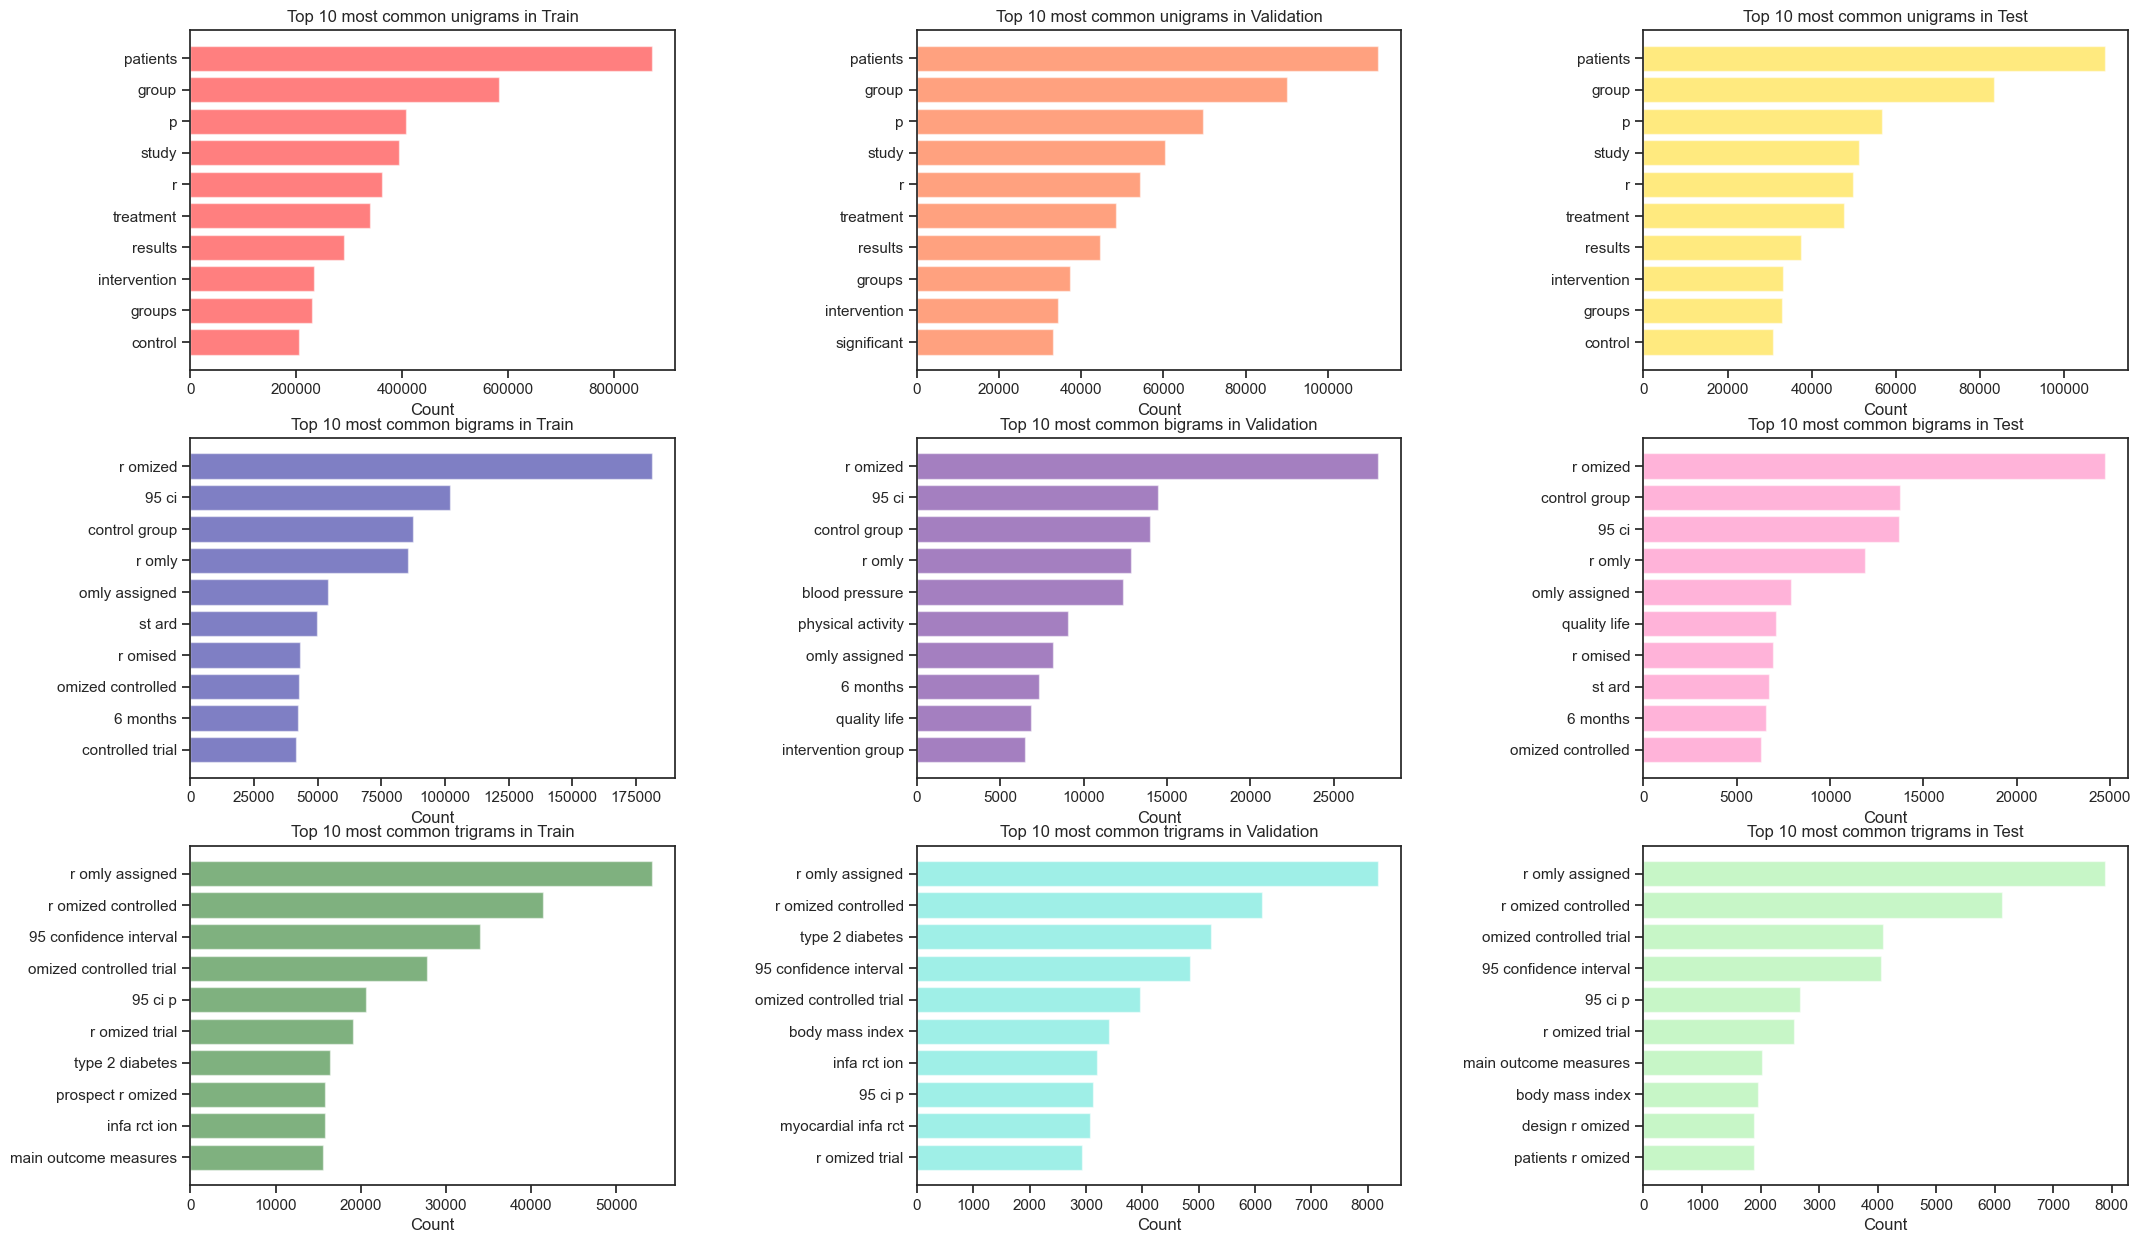

In [720]:
plotNgrams(df_train['abstract'], df_val['abstract'], df_test['abstract'])

### Target Ngram Anlaysis

(22764, 2)
(277677, 2)
(408435, 2)
(7590, 2)
(48032, 2)
(60100, 2)
Skipping processing and plotting for 'target' in test_documents.


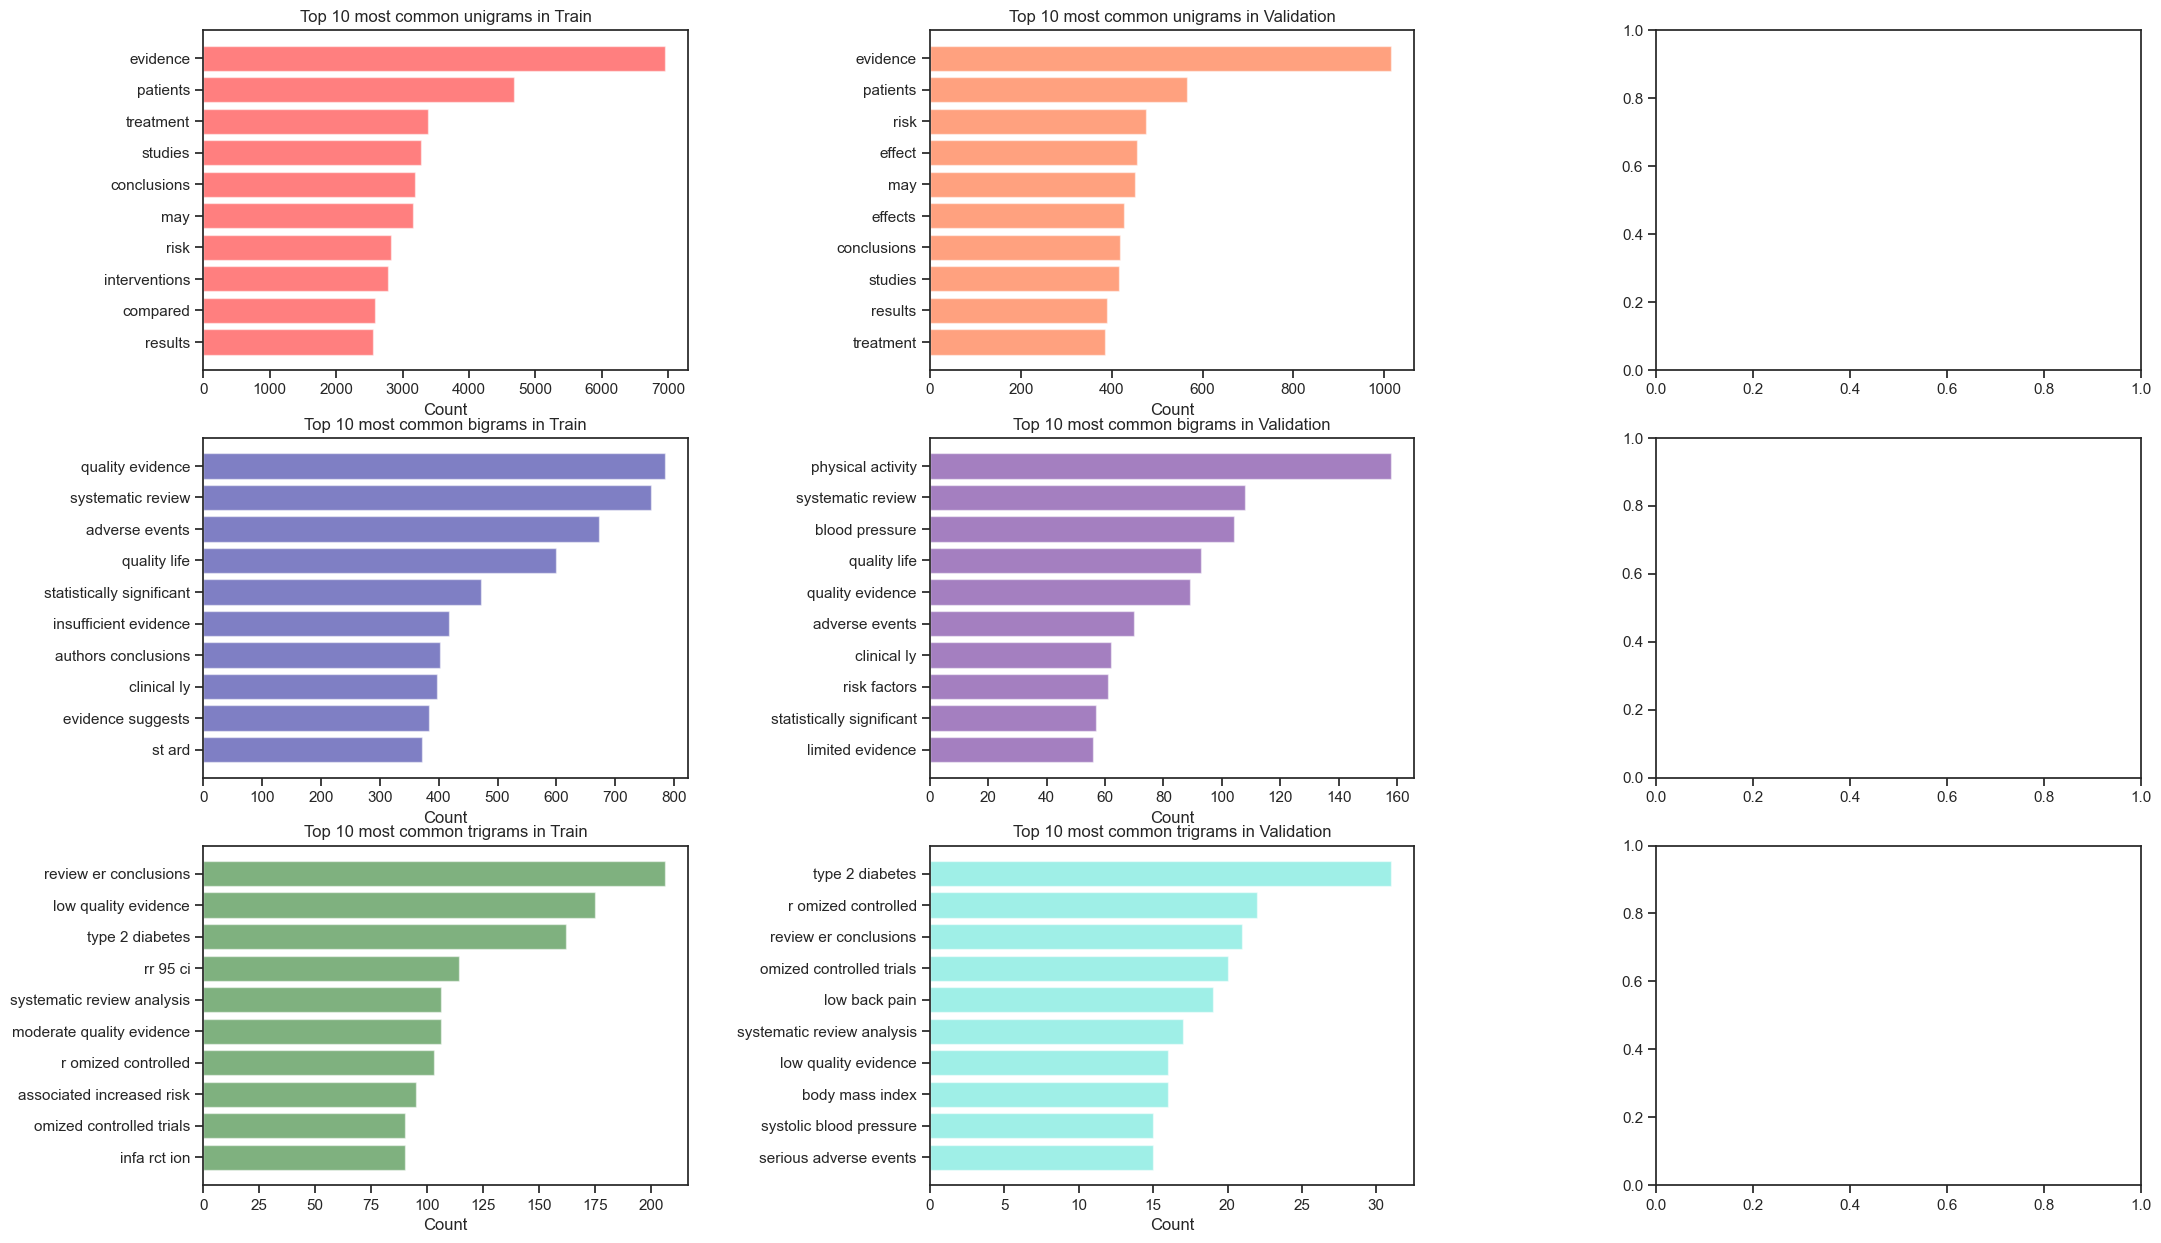

In [721]:
plotNgrams(df_train['target'], df_val['target'], df_test['target'])

# Pre-processing

In [372]:
train = load_dataset("allenai/mslr2022", "ms2", split="train")
val = load_dataset("allenai/mslr2022", "ms2", split="validation")

## Drop unused columns

In [373]:
# Drop columns other than 'abstract' and 'target'
train_clean = train.remove_columns(['review_id', 'pmid', 'title', 'background'])
val_clean = val.remove_columns(['review_id', 'pmid', 'title', 'background'])

## Lowercasing

In [374]:
def lowercase(dataset):
    dataset['abstract'] = [study.lower() for study in dataset['abstract']]
    dataset['target'] = dataset['target'].lower()
    return dataset

In [375]:
train_clean = train_clean.map(lowercase)
val_clean = val_clean.map(lowercase)

## Remove duplicates

In [376]:
def remove_duplicates(dataset):
    unique_abstracts = set()
    unique_targets = set()

    # Create a new list to store the cleaned data
    cleaned_data = []

    for row in dataset:
        # Extract 'abstract' and 'target' from the row
        abstract = row['abstract']
        target = row['target']

        # Convert the abstract to a frozenset
        abstract_frozenset = frozenset(abstract)

        # Check if this frozenset is unique
        if abstract_frozenset not in unique_abstracts and target not in unique_targets:
            # If unique, append the row to the cleaned data
            cleaned_data.append(row)

            # Add the frozenset and target to the sets of unique values
            unique_abstracts.add(abstract_frozenset)
            unique_targets.add(target)

    # Convert the cleaned data back to a Dataset
    cleaned_dataset = Dataset.from_dict({
        'abstract': [row['abstract'] for row in cleaned_data],
        'target': [row['target'] for row in cleaned_data]
    })

    return cleaned_dataset


In [377]:
train_clean = remove_duplicates(train_clean)
val_clean = remove_duplicates(val_clean)

In [378]:
train_clean

Dataset({
    features: ['abstract', 'target'],
    num_rows: 14141
})

In [379]:
val_clean

Dataset({
    features: ['abstract', 'target'],
    num_rows: 2014
})

## Text pre-processing

In [380]:
# Removal of hyperlinks
def remove_url(dataset):
    url_pattern = re.compile(r'clinical [A-Za-z0-9]+.gov+[^\s]+|clinical [A-Za-z0-9]+.gov|[A-Za-z0-9]+:/[^\s]+|[A-Za-z0-9]+://')
    
    dataset['abstract'] = [re.sub(url_pattern, ' ', study) for study in dataset['abstract']]
    dataset['target'] = re.sub(url_pattern, ' ', dataset['target'])
    
    return dataset

In [381]:
train_clean = train_clean.map(remove_url)
val_clean = val_clean.map(remove_url)

Map:   0%|          | 0/14141 [00:00<?, ? examples/s]

Map:   0%|          | 0/2014 [00:00<?, ? examples/s]

In [ ]:
# df_dist = pd.DataFrame()
# df1 = pd.DataFrame(train_clean)
# df2 = pd.DataFrame(val_clean)
# df_dist['url_count'] = df1['abstract'].apply(lambda x: len([w for w in str(x).lower().split() if 'http:' in w or 'https:' in w]))
# df_dist['url_count'] = df1['target'].apply(lambda x: len([w for w in str(x).lower().split() if 'http:' in w or 'https:' in w]))
# df_dist['url_count'] = df2['abstract'].apply(lambda x: len([w for w in str(x).lower().split() if 'http:' in w or 'https:' in w]))
# df_dist['url_count'] = df2['target'].apply(lambda x: len([w for w in str(x).lower().split() if 'http:' in w or 'https:' in w]))
# df_dist.describe()

In [388]:
def correct_typos(dataset):
    typos = ["r and omized", "r and omised", "r and omly", "clinical ly", "method ological", "st and ard", "review er", "review ers"]
    corrections = ["randomized", "randomised", "randomly", "clinically", "methodological", "standard", "reviewer", "reviewers"]
    
    corrected_abstracts = []
    corrected_targets = []
    
    for idx, row in enumerate(dataset): 
        abstract = row['abstract']
        target = row['target']
        
        # Correct typos in abstract
        corrected_abstract = []
        for i, study in enumerate(abstract):
            corrected_study = study
            for j, typo in enumerate(typos):
                typo_index = corrected_study.find(typo)
                while typo_index != -1:  # While typo is found
                    # Replace the typo with its correction
                    corrected_study = corrected_study[:typo_index] + corrections[j] + corrected_study[typo_index + len(typo):]
                    # print(f"Typo corrected in study {i+1} of abstract {idx}: {typo} -> {corrections[j]}")
                    # Find the next occurrence of the typo
                    typo_index = corrected_study.find(typo, typo_index + 1)
            corrected_abstract.append(corrected_study)
        
        # Correct typos in target
        corrected_target = target
        for k, typo in enumerate(typos):
            typo_index = corrected_target.find(typo)
            while typo_index != -1:  # While typo is found
                # Replace the typo with its correction
                corrected_target = corrected_target[:typo_index] + corrections[k] + corrected_target[typo_index + len(typo):]
                # print(f"Typo corrected in target {idx}: {typo} -> {corrections[k]}")
                # Find the next occurrence of the typo
                typo_index = corrected_target.find(typo, typo_index + 1)
        
        # Append corrected abstract and target to lists
        corrected_abstracts.append(corrected_abstract)
        corrected_targets.append(corrected_target)
        
    # Convert to dictionary format
    data_dict = {'abstract': corrected_abstracts, 'target': corrected_targets}

    # Create the Dataset object
    corrected_dataset = Dataset.from_dict(data_dict)
    
    return corrected_dataset


In [389]:
train_clean = correct_typos(train_clean)
val_clean = correct_typos(val_clean)

## Statistics summary of cleaned dataset

In [393]:
# Save cleaned dataset
train_clean.save_to_disk("train.hf")
val_clean.save_to_disk("val.hf")

Saving the dataset (0/2 shards):   0%|          | 0/14141 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2014 [00:00<?, ? examples/s]

In [394]:
df_train = pd.DataFrame(train_clean)
df_val = pd.DataFrame(val_clean)

In [397]:
ab_dist_train = create_text_features(df_train, 'abstract')
ab_dist_val = create_text_features(df_val, 'abstract')

tar_dist_train = create_text_features(df_train, 'target')
tar_dist_val = create_text_features(df_val, 'target')

In [398]:
ab_dist_train.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.0,14141.000000
mean,5759.161233,1184.257195,1915.466162,5.485515,38369.429107,0.0,1460.337388
std,6110.486848,657.594840,2024.819648,0.190722,40845.100537,0.0,1577.080846
min,38.000000,29.000000,10.000000,4.724590,257.000000,0.0,8.000000
25%,2499.000000,760.000000,834.000000,5.361406,16624.000000,0.0,595.000000
50%,4139.000000,1060.000000,1378.000000,5.479862,27591.000000,0.0,1036.000000
75%,6845.000000,1446.000000,2268.000000,5.603363,45587.000000,0.0,1746.000000
max,104057.000000,8724.000000,36384.000000,6.540000,705291.000000,0.0,27128.000000


In [399]:
ab_dist_val.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.0,2014.000000
mean,6164.732870,1247.625124,2031.255710,5.465745,40922.265144,0.0,1620.005958
std,6050.277238,659.321472,1975.565656,0.188379,40057.037535,0.0,1662.216608
min,108.000000,70.000000,47.000000,4.734066,752.000000,0.0,22.000000
25%,2752.750000,805.000000,914.000000,5.340828,18532.500000,0.0,671.000000
50%,4501.500000,1113.500000,1473.500000,5.463338,29814.500000,0.0,1153.000000
75%,7257.500000,1530.500000,2383.750000,5.590383,48024.250000,0.0,1947.250000
max,71309.000000,5812.000000,23133.000000,6.159190,482596.000000,0.0,20129.000000


In [400]:
tar_dist_train.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,14141.000000,14141.000000,14141.000000,14141.000000,14141.000000,14141.0,14141.000000
mean,55.467647,40.610494,20.092285,5.876735,383.545365,0.0,7.352309
std,39.279653,21.783239,14.795744,0.615045,270.576621,0.0,9.161898
min,1.000000,1.000000,0.000000,3.692308,11.000000,0.0,0.000000
25%,28.000000,25.000000,10.000000,5.466667,194.000000,0.0,3.000000
50%,45.000000,36.000000,16.000000,5.836735,309.000000,0.0,5.000000
75%,72.000000,52.000000,26.000000,6.235294,498.000000,0.0,9.000000
max,435.000000,246.000000,168.000000,11.844828,3101.000000,0.0,576.000000


In [401]:
tar_dist_val.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,url_count,punctuation_count
count,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2014.0,2014.000000
mean,55.256703,40.500497,20.027309,5.878197,382.040715,0.0,7.371897
std,36.878948,20.525698,14.006306,0.579868,253.603659,0.0,7.923205
min,6.000000,6.000000,0.000000,4.000000,49.000000,0.0,0.000000
25%,28.000000,25.000000,10.000000,5.506124,195.000000,0.0,3.000000
50%,46.000000,36.000000,16.000000,5.856108,315.500000,0.0,5.000000
75%,74.000000,52.000000,27.000000,6.216667,511.000000,0.0,9.000000
max,428.000000,236.000000,184.000000,8.818182,2733.000000,0.0,96.000000


## Data annotation

In [67]:
train = load_from_disk('train.hf')
val = load_from_disk('val.hf')

In [68]:
# Use a pipeline as a high-level helper
classify = pipeline("token-classification", model="kamalkraj/BioELECTRA-PICO", aggregation_strategy='simple')

In [69]:
def map_to_original(dataset, pio_abs_annotations, pio_tar_annotations):
  annotated_abstracts = []
  annotated_targets = []

  for idx, row in enumerate(dataset):
      abstract = row['abstract']
      target = row['target']
      # print(target)
      annotated_abstract = []

      for study, text in enumerate(abstract):
          abs_offset = 0  # Initialize the offset
          annotated_text = text  # Start with the original first study text in the abstract

          for entity in pio_abs_annotations[idx][study]:
            # print(entity)
            start_index = entity['start'] + abs_offset  # Adjust start index based on previous modifications and offset
            end_index = entity['end'] + abs_offset  # Adjust end index based on previous modifications and offset

            # Add <ent> tags to the annotated sentence
            annotated_text = annotated_text[:start_index] + "<ent>" + annotated_text[start_index:end_index] + "</ent>" + annotated_text[end_index:]

            # Update the offset based on the length of the inserted tags
            abs_offset += len("<ent>") + len("</ent>")

          # Append the annotated sentence to the list of annotated abstracts
          annotated_abstract.append(annotated_text)

      # Append the annotated abstract to the list of all annotated abstracts
      annotated_abstracts.append(annotated_abstract)


      tar_offset = 0 # Initialize the offset
      annotated_tar = target
      for entity in pio_tar_annotations[idx]:
        start_index = entity['start'] + tar_offset
        end_index = entity['end'] + tar_offset

        # Add <ent> tags to the annotated sentence
        annotated_tar = annotated_tar[:start_index] + "<ent>" + annotated_tar[start_index:end_index] + "</ent>" + annotated_tar[end_index:]

        # Update the offset based on the length of the inserted tags
        tar_offset += len("<ent>") + len("</ent>")

      # Append the annotated sentence to the list of annotated abstracts
      annotated_targets.append(annotated_tar)
      
  # Convert to dictionary format
  # data_dict = {'abstract': [abstract for abstract in annotated_abstracts], 'target': [target for target in annotated_targets]}
  
  # Convert to dictionary format
  data_dict = {'abstract': annotated_abstracts, 'target': annotated_targets}
  
  # Create the Dataset object
  annotated_dataset = Dataset.from_dict(data_dict)
  
  return annotated_dataset

In [70]:
def truncate_to_last_space(text):   
    # Find the last space character in the text
    last_space_index = text.rfind(' ')
        
    # # If no space is found, or if the last space is at the end of the text,
    # # return the original text to avoid breaking the last word
    # if last_space_index == -1 or last_space_index == len(text) - 1:
    #     return text
    
    # Truncate the text to the position of the last space character
    truncated_text = text[:last_space_index]
    return truncated_text


In [71]:
def annotate(dataset):
    pio_abs_annotations = []
    pio_tar_annotations = []
    total_rows = len(dataset)
    
    # for row in dataset:
    for i, row in enumerate(dataset):
        # Counter for the current row
        current_row = i + 1
        percentage_complete = (current_row / total_rows) * 100
        print(f"Processing row {current_row}/{total_rows} - {percentage_complete:.2f}% complete")
        
        # Extract 'abstract' and 'target' from the row
        abstract = row['abstract']
        target = row['target']
        full_target = len(target)
        
        study_annotations = []
        for study in abstract:
            full_study = len(study)
            if full_study <= 950:
                # If the study length is less than or equal to 950, directly annotate it
                study_annotations.append(classify(study))
            else:
                # If the study length exceeds 950, truncate it and then annotate
                first_part = study[:950]
                # Ensure that the last character is a space by truncating if needed
                truncated_first_part = truncate_to_last_space(first_part)
                first_part_annotation = classify(truncated_first_part)
                full_annotation = first_part_annotation

                # Annotate the remaining part of the study
                offset = len(truncated_first_part)
                remaining_study = study[offset:]
                while len(remaining_study) > 950:
                    # Ensure that the last character is a space by truncating if needed
                    truncated_remaining_study = truncate_to_last_space(remaining_study[:950])
                    truncated_annotation = classify(truncated_remaining_study)
                    for annotation in truncated_annotation:
                        annotation['start'] += offset
                        annotation['end'] += offset
                    offset += len(truncated_remaining_study)
                    full_annotation.extend(truncated_annotation)
                    # Update the remaining part of the study
                    remaining_study = remaining_study[len(truncated_remaining_study):]
                else:
                    # Ensure that the last character is a space by truncating if needed
                    if len(remaining_study) <= 950:
                        truncated_annotation = classify(remaining_study)
                        for annotation in truncated_annotation:
                            annotation['start'] += offset
                            annotation['end'] += offset
                        full_annotation.extend(truncated_annotation)
                        
                # Append the full annotation of the study to study_annotations
                study_annotations.append(full_annotation)
        
        pio_abs_annotations.append(study_annotations)
        
        if full_target <= 950:
            # If the target length is less than or equal to 950, directly annotate it
            pio_tar_annotations.append(classify(target))
        else:
            # If the target length exceeds 950, truncate it and then annotate
            first_part = target[:950]
            # Ensure that the last character is a space by truncating if needed
            truncated_first_part = truncate_to_last_space(first_part)
            first_part_annotation = classify(truncated_first_part)
            full_annotation = first_part_annotation

            # Annotate the remaining part of the target
            offset = len(truncated_first_part)
            remaining_target = target[offset:]
            while len(remaining_target) > 950:
                # Ensure that the last character is a space by truncating if needed
                truncated_remaining_target = truncate_to_last_space(remaining_target[:950])
                truncated_annotation = classify(truncated_remaining_target)
                for annotation in truncated_annotation:
                    annotation['start'] += offset
                    annotation['end'] += offset
                offset += len(truncated_remaining_target)
                full_annotation.extend(truncated_annotation)
                # Update the remaining part of the target
                remaining_target = remaining_target[len(truncated_remaining_target):]
            else:
                # Ensure that the last character is a space by truncating if needed
                if len(remaining_target) <= 950:
                    truncated_annotation = classify(remaining_target)
                    for annotation in truncated_annotation:
                        annotation['start'] += offset
                        annotation['end'] += offset
                    full_annotation.extend(truncated_annotation)
                    
            # Append the full annotation of the target to pio_tar_annotations
            pio_tar_annotations.append(full_annotation)

    annotated_dataset = map_to_original(dataset, pio_abs_annotations, pio_tar_annotations)
    
    return annotated_dataset


### Train set

In [82]:
for shard_index in range(5):
    exec(f"shard_{shard_index} = train.shard(num_shards=5, index={shard_index}, contiguous=True)")
    print(f"shard_{shard_index}")


shard_0
shard_1
shard_2
shard_3
shard_4


In [83]:
tr0_annotated = annotate(shard_0)
tr0_annotated.save_to_disk("train0_pio.hf")

Processing row 1/2829 - 0.04% complete
Processing row 2/2829 - 0.07% complete
Processing row 3/2829 - 0.11% complete
Processing row 4/2829 - 0.14% complete
Processing row 5/2829 - 0.18% complete
Processing row 6/2829 - 0.21% complete
Processing row 7/2829 - 0.25% complete
Processing row 8/2829 - 0.28% complete
Processing row 9/2829 - 0.32% complete
Processing row 10/2829 - 0.35% complete
Processing row 11/2829 - 0.39% complete
Processing row 12/2829 - 0.42% complete
Processing row 13/2829 - 0.46% complete
Processing row 14/2829 - 0.49% complete
Processing row 15/2829 - 0.53% complete
Processing row 16/2829 - 0.57% complete
Processing row 17/2829 - 0.60% complete
Processing row 18/2829 - 0.64% complete
Processing row 19/2829 - 0.67% complete
Processing row 20/2829 - 0.71% complete
Processing row 21/2829 - 0.74% complete
Processing row 22/2829 - 0.78% complete
Processing row 23/2829 - 0.81% complete
Processing row 24/2829 - 0.85% complete
Processing row 25/2829 - 0.88% complete
Processin

Saving the dataset (0/1 shards):   0%|          | 0/2829 [00:00<?, ? examples/s]

In [84]:
tr1_annotated = annotate(shard_1)
tr1_annotated.save_to_disk("train1_pio.hf")

Processing row 1/2828 - 0.04% complete
Processing row 2/2828 - 0.07% complete
Processing row 3/2828 - 0.11% complete
Processing row 4/2828 - 0.14% complete
Processing row 5/2828 - 0.18% complete
Processing row 6/2828 - 0.21% complete
Processing row 7/2828 - 0.25% complete
Processing row 8/2828 - 0.28% complete
Processing row 9/2828 - 0.32% complete
Processing row 10/2828 - 0.35% complete
Processing row 11/2828 - 0.39% complete
Processing row 12/2828 - 0.42% complete
Processing row 13/2828 - 0.46% complete
Processing row 14/2828 - 0.50% complete
Processing row 15/2828 - 0.53% complete
Processing row 16/2828 - 0.57% complete
Processing row 17/2828 - 0.60% complete
Processing row 18/2828 - 0.64% complete
Processing row 19/2828 - 0.67% complete
Processing row 20/2828 - 0.71% complete
Processing row 21/2828 - 0.74% complete
Processing row 22/2828 - 0.78% complete
Processing row 23/2828 - 0.81% complete
Processing row 24/2828 - 0.85% complete
Processing row 25/2828 - 0.88% complete
Processin

Saving the dataset (0/1 shards):   0%|          | 0/2828 [00:00<?, ? examples/s]

In [85]:
tr2_annotated = annotate(shard_2)
tr2_annotated.save_to_disk("train2_pio.hf")

Processing row 1/2828 - 0.04% complete
Processing row 2/2828 - 0.07% complete
Processing row 3/2828 - 0.11% complete
Processing row 4/2828 - 0.14% complete
Processing row 5/2828 - 0.18% complete
Processing row 6/2828 - 0.21% complete
Processing row 7/2828 - 0.25% complete
Processing row 8/2828 - 0.28% complete
Processing row 9/2828 - 0.32% complete
Processing row 10/2828 - 0.35% complete
Processing row 11/2828 - 0.39% complete
Processing row 12/2828 - 0.42% complete
Processing row 13/2828 - 0.46% complete
Processing row 14/2828 - 0.50% complete
Processing row 15/2828 - 0.53% complete
Processing row 16/2828 - 0.57% complete
Processing row 17/2828 - 0.60% complete
Processing row 18/2828 - 0.64% complete
Processing row 19/2828 - 0.67% complete
Processing row 20/2828 - 0.71% complete
Processing row 21/2828 - 0.74% complete
Processing row 22/2828 - 0.78% complete
Processing row 23/2828 - 0.81% complete
Processing row 24/2828 - 0.85% complete
Processing row 25/2828 - 0.88% complete
Processin

Saving the dataset (0/1 shards):   0%|          | 0/2828 [00:00<?, ? examples/s]

In [86]:
tr3_annotated = annotate(shard_3)
tr3_annotated.save_to_disk("train3_pio.hf")

Processing row 1/2828 - 0.04% complete
Processing row 2/2828 - 0.07% complete
Processing row 3/2828 - 0.11% complete
Processing row 4/2828 - 0.14% complete
Processing row 5/2828 - 0.18% complete
Processing row 6/2828 - 0.21% complete
Processing row 7/2828 - 0.25% complete
Processing row 8/2828 - 0.28% complete
Processing row 9/2828 - 0.32% complete
Processing row 10/2828 - 0.35% complete
Processing row 11/2828 - 0.39% complete
Processing row 12/2828 - 0.42% complete
Processing row 13/2828 - 0.46% complete
Processing row 14/2828 - 0.50% complete
Processing row 15/2828 - 0.53% complete
Processing row 16/2828 - 0.57% complete
Processing row 17/2828 - 0.60% complete
Processing row 18/2828 - 0.64% complete
Processing row 19/2828 - 0.67% complete
Processing row 20/2828 - 0.71% complete
Processing row 21/2828 - 0.74% complete
Processing row 22/2828 - 0.78% complete
Processing row 23/2828 - 0.81% complete
Processing row 24/2828 - 0.85% complete
Processing row 25/2828 - 0.88% complete
Processin

Saving the dataset (0/1 shards):   0%|          | 0/2828 [00:00<?, ? examples/s]

In [87]:
tr4_annotated = annotate(shard_4)
tr4_annotated.save_to_disk("train4_pio.hf")

Processing row 1/2828 - 0.04% complete
Processing row 2/2828 - 0.07% complete
Processing row 3/2828 - 0.11% complete
Processing row 4/2828 - 0.14% complete
Processing row 5/2828 - 0.18% complete
Processing row 6/2828 - 0.21% complete
Processing row 7/2828 - 0.25% complete
Processing row 8/2828 - 0.28% complete
Processing row 9/2828 - 0.32% complete
Processing row 10/2828 - 0.35% complete
Processing row 11/2828 - 0.39% complete
Processing row 12/2828 - 0.42% complete
Processing row 13/2828 - 0.46% complete
Processing row 14/2828 - 0.50% complete
Processing row 15/2828 - 0.53% complete
Processing row 16/2828 - 0.57% complete
Processing row 17/2828 - 0.60% complete
Processing row 18/2828 - 0.64% complete
Processing row 19/2828 - 0.67% complete
Processing row 20/2828 - 0.71% complete
Processing row 21/2828 - 0.74% complete
Processing row 22/2828 - 0.78% complete
Processing row 23/2828 - 0.81% complete
Processing row 24/2828 - 0.85% complete
Processing row 25/2828 - 0.88% complete
Processin

Saving the dataset (0/1 shards):   0%|          | 0/2828 [00:00<?, ? examples/s]

In [92]:
# Combine and save train dataset
tr_annotated = concatenate_datasets([tr0_annotated, tr1_annotated, tr2_annotated, tr3_annotated, tr4_annotated])
tr_annotated.save_to_disk("train_pio.hf")

Saving the dataset (0/2 shards):   0%|          | 0/14141 [00:00<?, ? examples/s]

### Validation set

In [407]:
val_annotated = annotate(val)
val_annotated.save_to_disk("val_pio.hf")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Processing row 1/2014 - 0.05% complete
Processing row 2/2014 - 0.10% complete
Processing row 3/2014 - 0.15% complete
Processing row 4/2014 - 0.20% complete
Processing row 5/2014 - 0.25% complete
Processing row 6/2014 - 0.30% complete
Processing row 7/2014 - 0.35% complete
Processing row 8/2014 - 0.40% complete
Processing row 9/2014 - 0.45% complete
Processing row 10/2014 - 0.50% complete
Processing row 11/2014 - 0.55% complete
Processing row 12/2014 - 0.60% complete
Processing row 13/2014 - 0.65% complete
Processing row 14/2014 - 0.70% complete
Processing row 15/2014 - 0.74% complete
Processing row 16/2014 - 0.79% complete
Processing row 17/2014 - 0.84% complete
Processing row 18/2014 - 0.89% complete
Processing row 19/2014 - 0.94% complete
Processing row 20/2014 - 0.99% complete
Processing row 21/2014 - 1.04% complete
Processing row 22/2014 - 1.09% complete
Processing row 23/2014 - 1.14% complete
Processing row 24/2014 - 1.19% complete
Processing row 25/2014 - 1.24% complete
Processin

Saving the dataset (0/1 shards):   0%|          | 0/2014 [00:00<?, ? examples/s]

## Word Count of Annotated Data

In [ ]:
# Statistics of annotated dataset
# Concatenate the datasets together
combined_dataset = concatenate_datasets([tr_annotated, val_annotated])
combined_dataset = pd.DataFrame(combined_dataset)

# Only word count with punctuation as pre-trained tokenizer takes into account of punctuation
ab_combined = create_text_features(combined_dataset, 'abstract')
tar_combined = create_text_features(combined_dataset, 'target')

In [ ]:
# For Abstract in Train and Validation Set
# Get the statistics DataFrame using describe()
statistics_df = ab_combined.describe()

# Calculate the 90th percentile separately
percentile_90 = ab_combined.describe(percentiles=[.90]).loc['90%']

# Append the 90th percentile as a new row to the statistics DataFrame
statistics_df.loc['90%'] = percentile_90
statistics_df = statistics_df.reindex(['count', 'mean', 'std', 'min', '25%', '50%', '75%', '90%', 'max'])
statistics_df = statistics_df.round(3)
statistics_df

,word_count
count,16155.000
mean,6843.346
std,7189.667
min,43.000
25%,2954.500
50%,4925.000
75%,8143.500
90%,13422.200
max,121423.000


In [ ]:
# For Target in Train and Validation Set
# Get the statistics DataFrame using describe()
statistics_df = tar_combined.describe()

# Calculate the 90th percentile separately
percentile_90 = tar_combined.describe(percentiles=[.90]).loc['90%']

# Append the 90th percentile as a new row to the statistics DataFrame
statistics_df.loc['90%'] = percentile_90
statistics_df = statistics_df.reindex(['count', 'mean', 'std', 'min', '25%', '50%', '75%', '90%', 'max'])
statistics_df = statistics_df.round(3)
statistics_df

,word_count
count,16155.000
mean,61.056
std,43.885
min,2.000
25%,30.000
50%,49.000
75%,79.000
90%,117.000
max,484.000
